In [1]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

from data_builder import *
from utils import *
import torch
import numpy as np
import matplotlib.pyplot as plt

# %%

num_trajectories = 20
n_test_traj = 2
num_nodes = 2
T_max = 10.01
T_max_t = 10.01
dt = 0.01
srate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 0)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)
print(train_data['x'].shape)
tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)
print(tnow.shape)

traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
train_dataloader = DataLoader(traindat, batch_size=1500, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=1500, num_workers=2, shuffle=False)

data_dict = {'train': train_dataloader, 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}

torch.pi = torch.tensor(np.pi)


def train_model(model, optimizer,lr_sched, num_epochs=1, energy_term=False, integrator_embedded=False, reg_grad=False):
    for epoch in range(num_epochs):
        print('epoch:{}'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()
            lr_sched.step()
            running_loss = 0.0
            # Iterate over data.
            for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict[phase]):
                if phase == 'train':
                    optimizer.zero_grad()
                q, q_next, qdx = q.float(), q_next.float(), qdx.float()
                q.to(device)
                q_next.to(device)
                energy_.to(device)
                qdx.to(device)
                tevals = tevals.float()
                tevals.to(device)
                loss = 0
                q.requires_grad = True
                tevals.requires_grad = True

                if integrator_embedded:
                    next_step_pred = model.next_step(q,tevals)
                    state_loss = torch.mean((next_step_pred - q_next) ** 2)
                else:
                    next_step_pred = model.time_deriv(q,tevals)
                    state_loss = torch.mean((next_step_pred - qdx) ** 2)

                loss = state_loss
                print(f'{phase} state loss {state_loss}')

                beta = 1e-5

                if energy_term:
                    f1 = model.get_H(torch.cat([q,tevals.reshape(-1,1)],1))
                    energy_loss = ((f1 - energy_) ** 2).mean()
                    print(f'{phase} energy loss {energy_loss}')
                    loss += beta*energy_loss

                lambda_ = 1

                if reg_grad:
                    dhdt,dfdq,dfdp = model.time_deriv2(q, tevals)
                    c1 = torch.mean(torch.square(dhdt))
                    c2 = torch.mean(torch.square(dfdq))
                    c3 = torch.mean(torch.square(dfdp))
                    loss += c1 + c2 + c3

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += state_loss

            loss_collater[phase].append(running_loss)
            epoch_loss = running_loss
            print('{} Loss: {:.10f}'.format(phase, epoch_loss))

    plt.figure()
    plt.plot(loss_collater['train'], label='train')
    plt.plot(loss_collater['valid'], label='valid')
    plt.yscale('log')
    plt.title(f'simple pendulum: ntrain_inits:{num_trajectories},ntest_inits:{n_test_traj},tmax:{T_max},dt:{dt}')
    plt.legend()
    plt.show()
    #
    #
    #
    # preds = []
    # pred_ham = []
    # qinit = q[0].reshape(1, -1)
    # for i in range(len(q_next)):
    #     next_step_pred = model.next_step(qinit,tevals[i])
    #     pred_ham.append(model.get_H(torch.cat([qinit,tevals[i].reshape(-1,1)],1)))
    #     preds.append(next_step_pred)
    #     qinit = next_step_pred
    #
    # # pred_ham = torch.cat(pred_ham)
    #
    # # plt.figure()
    # # plt.scatter(range(len(q_next)),pred_ham.detach().numpy())
    # # plt.show()
    #
    # preds = torch.cat(preds)
    # preds = preds.detach().numpy()
    # q_next = q_next.detach().numpy()
    #
    # plt.figure()
    # plt.scatter(range(len(preds)),np.mean(np.abs(preds-q_next),1))
    # plt.show()
    #
    #
    # print(np.mean((preds-q_next)**2))
    # plt.figure()
    # plt.plot(preds[:, 0], preds[:, 1], label='predicted')
    # plt.plot(q_next[:, 0], q_next[:, 1], label='true')
    # plt.scatter(preds[:, 0], preds[:, 1], label='predicted', s=3)
    # plt.scatter(q_next[:, 0], q_next[:, 1], label='true', s=3)
    # plt.legend()
    # plt.show()
    return model
# model_ft = HNN(2, 200, 1, 0.01)


cpu
(20020, 2)
(20000, 2)


epoch:0


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train state loss 8.70154399308376e-05
train state loss 9.010396752273664e-05
train state loss 8.725127554498613e-05
train state loss 7.749279757263139e-05
train state loss 7.495505269616842e-05
train state loss 5.9170433814870194e-05
train state loss 6.210455467225984e-05
train state loss 0.00012423726730048656
train state loss 7.349604129558429e-05
train state loss 8.388285641558468e-05
train state loss 6.114300776971504e-05
train state loss 6.249266880331561e-05
train state loss 6.431280053220689e-05
train state loss 5.76140264456626e-05
train Loss: 0.0010652723
valid state loss 4.845119474339299e-05
valid state loss 6.979312456678599e-05
valid Loss: 0.0001182443
epoch:1
train state loss 5.1641196478158236e-05
train state loss 4.534712934400886e-05
train state loss 3.969765384681523e-05
train state loss 3.2287294743582606e-05
train state loss 3.169554838677868e-05
train state loss 3.22897540172562e-05
train state loss 2.8871365429949947e-05
train state loss 3.0272742151282728e-05
tra

valid state loss 1.0645760085026268e-05
valid Loss: 0.0000213398
epoch:12
train state loss 1.696532854111865e-05
train state loss 1.6757283447077498e-05
train state loss 1.6867150407051668e-05
train state loss 1.610473555047065e-05
train state loss 1.6572175809415057e-05
train state loss 1.6715728634153493e-05
train state loss 1.6500935089425184e-05
train state loss 1.5952022295095958e-05
train state loss 1.6999629224301316e-05
train state loss 1.5991983673302457e-05
train state loss 1.6717018297640607e-05
train state loss 1.7164426026283763e-05
train state loss 1.5669718777644448e-05
train state loss 1.6292036889353767e-05
train Loss: 0.0002312702
valid state loss 1.2952479664818384e-05
valid state loss 1.0599177585390862e-05
valid Loss: 0.0000235517
epoch:13
train state loss 1.6272633729386143e-05
train state loss 1.598448579898104e-05
train state loss 1.6435329598607495e-05
train state loss 1.5357696611317806e-05
train state loss 1.4875955457682721e-05
train state loss 1.53342552948

valid state loss 3.776556923185126e-06
valid state loss 4.023319434054429e-06
valid Loss: 0.0000077999
epoch:24
train state loss 5.253156814433169e-06
train state loss 5.166915343579603e-06
train state loss 5.836528998770518e-06
train state loss 6.1784530771547e-06
train state loss 6.347008820739575e-06
train state loss 5.962497652944876e-06
train state loss 4.873615580436308e-06
train state loss 5.679293735738611e-06
train state loss 6.25739721726859e-06
train state loss 4.565894869301701e-06
train state loss 5.476207661558874e-06
train state loss 6.044863312126836e-06
train state loss 6.765620128135197e-06
train state loss 5.999102086207131e-06
train Loss: 0.0000804066
valid state loss 5.850309662491782e-06
valid state loss 7.1303616095974576e-06
valid Loss: 0.0000129807
epoch:25
train state loss 6.196370122779626e-06
train state loss 6.663861313427333e-06
train state loss 5.216467343416298e-06
train state loss 5.634271929011447e-06
train state loss 5.050879735790659e-06
train state 

train state loss 1.0182337746300618e-06
train Loss: 0.0000136470
valid state loss 8.46154421196843e-07
valid state loss 9.955258519767085e-07
valid Loss: 0.0000018417
epoch:36
train state loss 9.973697387977154e-07
train state loss 1.0273906809743494e-06
train state loss 1.1058195923396852e-06
train state loss 1.5117526572794304e-06
train state loss 1.5451040553671191e-06
train state loss 1.3522403605747968e-06
train state loss 1.1450914598754025e-06
train state loss 9.381636800753768e-07
train state loss 9.727211818244541e-07
train state loss 1.0631628128976445e-06
train state loss 1.4004001513967523e-06
train state loss 1.3040821613685694e-06
train state loss 9.953893140846048e-07
train state loss 6.78159778999543e-07
train Loss: 0.0000160368
valid state loss 8.285461490231683e-07
valid state loss 7.73345334437181e-07
valid Loss: 0.0000016019
epoch:37
train state loss 7.684225238335785e-07
train state loss 7.5525485954131e-07
train state loss 7.86638565841713e-07
train state loss 7.8

train state loss 4.787845000464586e-07
train state loss 7.663565497750824e-07
train Loss: 0.0000111349
valid state loss 9.81912648967409e-07
valid state loss 1.6628044932076591e-06
valid Loss: 0.0000026447
epoch:48
train state loss 1.0712184348449227e-06
train state loss 1.015770749290823e-06
train state loss 5.193491006139084e-07
train state loss 5.080590312900313e-07
train state loss 7.811661930645641e-07
train state loss 1.002261114990688e-06
train state loss 1.0159282055610674e-06
train state loss 5.06791536736273e-07
train state loss 6.337667741718178e-07
train state loss 8.814856187200348e-07
train state loss 8.332619358952797e-07
train state loss 5.818382078359718e-07
train state loss 4.797952897206414e-07
train state loss 5.186951170799148e-07
train Loss: 0.0000103494
valid state loss 5.422853064374067e-07
valid state loss 5.402013698585506e-07
valid Loss: 0.0000010825
epoch:49
train state loss 6.153488243398897e-07
train state loss 8.12421319551504e-07
train state loss 7.77337

train state loss 7.706105975557875e-07
train state loss 6.787316806367016e-07
train Loss: 0.0000125823
valid state loss 7.541078730355366e-07
valid state loss 1.0866854154301109e-06
valid Loss: 0.0000018408
epoch:60
train state loss 8.569881515541056e-07
train state loss 5.697816050087567e-07
train state loss 8.850296353557496e-07
train state loss 1.0037889524028287e-06
train state loss 8.140352747432189e-07
train state loss 7.11683810550312e-07
train state loss 8.169554917003552e-07
train state loss 1.1117102758362307e-06
train state loss 1.0647603403413086e-06
train state loss 1.0068629308079835e-06
train state loss 7.544990126007178e-07
train state loss 7.375225550276809e-07
train state loss 1.1881057844220777e-06
train state loss 8.873035994838574e-07
train Loss: 0.0000124090
valid state loss 6.612566494368366e-07
valid state loss 5.394394406721403e-07
valid Loss: 0.0000012007
epoch:61
train state loss 6.780171020182024e-07
train state loss 7.259862968567177e-07
train state loss 7.

train state loss 3.2237051073025214e-07
train state loss 2.689989457849151e-07
train Loss: 0.0000062704
valid state loss 3.7223020399324014e-07
valid state loss 6.191808665789722e-07
valid Loss: 0.0000009914
epoch:72
train state loss 4.3893157908314606e-07
train state loss 5.217707439442165e-07
train state loss 3.8804424207228294e-07
train state loss 3.216912318748655e-07
train state loss 2.77876807786015e-07
train state loss 1.9800569361905218e-07
train state loss 2.5617990218052e-07
train state loss 2.768612716863572e-07
train state loss 2.4942383447523753e-07
train state loss 2.494264492725051e-07
train state loss 2.0090442376385909e-07
train state loss 1.8220526953882654e-07
train state loss 1.6317881090799347e-07
train state loss 1.879571556173687e-07
train Loss: 0.0000039125
valid state loss 1.1685904155456228e-07
valid state loss 1.244943348410743e-07
valid Loss: 0.0000002414
epoch:73
train state loss 1.4140356086045358e-07
train state loss 2.3858024178480264e-07
train state los

train state loss 1.9627893266260799e-07
train state loss 2.24953524252669e-07
train Loss: 0.0000034155
valid state loss 1.2741374177949183e-07
valid state loss 1.0866953203958474e-07
valid Loss: 0.0000002361
epoch:84
train state loss 1.6144474557222566e-07
train state loss 2.1459426591263764e-07
train state loss 3.781056818752404e-07
train state loss 4.2850908243963204e-07
train state loss 3.561450228062313e-07
train state loss 1.879166831031398e-07
train state loss 1.2410893646119803e-07
train state loss 1.9235640991155378e-07
train state loss 2.704271366837929e-07
train state loss 3.3086720918618084e-07
train state loss 1.75860165541053e-07
train state loss 1.3183637292968342e-07
train state loss 2.1408247619092435e-07
train state loss 3.790979690165841e-07
train Loss: 0.0000035454
valid state loss 3.503189986986399e-07
valid state loss 8.996073574962793e-07
valid Loss: 0.0000012499
epoch:85
train state loss 4.2035827618747135e-07
train state loss 3.336138831855351e-07
train state lo

train state loss 1.550988031340239e-07
train state loss 1.8181322047894355e-07
train state loss 1.3761429329406383e-07
train state loss 1.496418065016769e-07
train Loss: 0.0000036230
valid state loss 1.3129132980793656e-07
valid state loss 1.207425981419874e-07
valid Loss: 0.0000002520
epoch:96
train state loss 1.1815504308287927e-07
train state loss 2.1515414516670717e-07
train state loss 3.1055398608259566e-07
train state loss 3.9710675991955213e-07
train state loss 5.53250629309332e-07
train state loss 7.730640732006577e-07
train state loss 8.90871376668656e-07
train state loss 9.835569017013768e-07
train state loss 4.898311090073548e-07
train state loss 2.2820451306415634e-07
train state loss 2.853115859124955e-07
train state loss 5.726957965634938e-07
train state loss 5.862981993232097e-07
train state loss 5.880412459191575e-07
train Loss: 0.0000069921
valid state loss 2.274484955933076e-07
valid state loss 3.504856636027398e-07
valid Loss: 0.0000005779
epoch:97
train state loss 2

train state loss 2.2856730197418074e-07
train state loss 2.245118224664111e-07
train state loss 1.6315131290411955e-07
train state loss 1.197663834773266e-07
train state loss 1.8476114860277448e-07
train state loss 1.3194242853842297e-07
train Loss: 0.0000026223
valid state loss 9.488745433827717e-08
valid state loss 1.416097887840806e-07
valid Loss: 0.0000002365
epoch:108
train state loss 9.368984876800823e-08
train state loss 1.0000639605323158e-07
train state loss 1.4177321361330542e-07
train state loss 9.68476712159827e-08
train state loss 9.886905871780982e-08
train state loss 1.357184800099276e-07
train state loss 1.2488391121223685e-07
train state loss 7.458273643123903e-08
train state loss 1.1640770480880747e-07
train state loss 1.1763074780901661e-07
train state loss 1.265997866539692e-07
train state loss 1.3620116590118414e-07
train state loss 1.6209779118980805e-07
train state loss 1.3424097744518804e-07
train Loss: 0.0000016595
valid state loss 1.5104917849839694e-07
valid 

train state loss 1.0929981186791338e-07
train state loss 8.33999962424059e-08
train state loss 7.029463944263625e-08
train state loss 6.953440134793709e-08
train state loss 1.2973157481610542e-07
train state loss 1.5779295381435077e-07
train state loss 1.9167114828633203e-07
train state loss 1.791963768482674e-07
train Loss: 0.0000016839
valid state loss 1.0165376096438195e-07
valid state loss 3.466663258677727e-07
valid Loss: 0.0000004483
epoch:120
train state loss 1.4545149440436944e-07
train state loss 1.0197617683616045e-07
train state loss 6.51378968541394e-08
train state loss 5.4963756213055603e-08
train state loss 7.359764708780858e-08
train state loss 8.3715072207724e-08
train state loss 9.26158207903427e-08
train state loss 1.1539888333800263e-07
train state loss 1.101113369372797e-07
train state loss 9.727051519803354e-08
train state loss 8.336598966707243e-08
train state loss 6.24381897296189e-08
train state loss 4.318033575145819e-08
train state loss 4.691635524523008e-08
t

train state loss 2.063658577355909e-08
train state loss 2.1115116766168285e-08
train state loss 2.032838253285263e-08
train state loss 2.3458822440147742e-08
train state loss 2.1834154040334397e-08
train state loss 2.0877509498973268e-08
train state loss 1.9217763380652286e-08
train state loss 2.149664268813467e-08
train state loss 1.9381589666522814e-08
train state loss 2.2332107718625593e-08
train Loss: 0.0000002996
valid state loss 2.0181925464157757e-08
valid state loss 2.2781794228876606e-08
valid Loss: 0.0000000430
epoch:132
train state loss 1.97714697947049e-08
train state loss 2.1205391220746606e-08
train state loss 2.1566503249914604e-08
train state loss 2.0335717110242513e-08
train state loss 2.0351791363282246e-08
train state loss 2.1465536903519933e-08
train state loss 2.0882104934116796e-08
train state loss 2.0446218940151084e-08
train state loss 2.024997769467518e-08
train state loss 2.1874408062672046e-08
train state loss 2.1715800713195677e-08
train state loss 2.1770926

train state loss 1.8559973113951855e-08
train state loss 1.6131840752109383e-08
train state loss 1.8273292212711567e-08
train state loss 1.822624895453373e-08
train state loss 1.6921601897479377e-08
train state loss 1.5940921471724323e-08
train state loss 1.9067819323481672e-08
train state loss 1.723000764286553e-08
train state loss 1.7044975209046243e-08
train state loss 1.848733610643194e-08
train state loss 1.751730493992909e-08
train state loss 1.5718748969106855e-08
train Loss: 0.0000002464
valid state loss 1.51752388433124e-08
valid state loss 1.4395983072290619e-08
valid Loss: 0.0000000296
epoch:144
train state loss 1.8339905594189077e-08
train state loss 1.6427833315901808e-08
train state loss 1.686114359245039e-08
train state loss 1.93201383780206e-08
train state loss 1.6860735030377327e-08
train state loss 1.8145014379911117e-08
train state loss 1.8871233464778925e-08
train state loss 1.7304447652577437e-08
train state loss 1.7469609758791194e-08
train state loss 1.5943134812

train state loss 1.5908508288475787e-08
train state loss 1.492854551088385e-08
train state loss 1.4777961965251052e-08
train state loss 1.5696661748165752e-08
train state loss 1.668547611188842e-08
train state loss 1.5768772954061205e-08
train state loss 1.5990412549626853e-08
train state loss 1.528426452068743e-08
train state loss 1.739753052731885e-08
train state loss 1.63973510325377e-08
train state loss 1.5775679429452794e-08
train state loss 1.514754366382931e-08
train state loss 1.611354960573408e-08
train state loss 1.602004218170805e-08
train Loss: 0.0000002219
valid state loss 1.4025006933593431e-08
valid state loss 1.5699853861406154e-08
valid Loss: 0.0000000297
epoch:156
train state loss 1.658939119408842e-08
train state loss 1.6614226439060076e-08
train state loss 1.5792556595783935e-08
train state loss 1.678063554777509e-08
train state loss 1.5862367419572365e-08
train state loss 1.5076921044965275e-08
train state loss 1.6793592294561677e-08
train state loss 1.517171810405

valid state loss 1.4075056675721953e-08
valid state loss 1.1626946516685166e-08
valid Loss: 0.0000000257
epoch:167
train state loss 1.449224029670404e-08
train state loss 1.4794816038943281e-08
train state loss 1.4877607590335629e-08
train state loss 1.4824210303743257e-08
train state loss 1.359827006552905e-08
train state loss 1.4638164458347092e-08
train state loss 1.5478283543757243e-08
train state loss 1.4469765829971948e-08
train state loss 1.3970626433490452e-08
train state loss 1.521602044363135e-08
train state loss 1.4633042333400681e-08
train state loss 1.3316913793914864e-08
train state loss 1.5262914487834678e-08
train state loss 1.4696296624094884e-08
train Loss: 0.0000002043
valid state loss 1.2927879211588333e-08
valid state loss 1.1893431128839893e-08
valid Loss: 0.0000000248
epoch:168
train state loss 1.3743404636556988e-08
train state loss 1.419066375518696e-08
train state loss 1.4043621376913507e-08
train state loss 1.429684726161895e-08
train state loss 1.45324312583

train state loss 1.3377651875146057e-08
train state loss 1.2564735030196061e-08
train state loss 1.52184842505676e-08
train Loss: 0.0000001899
valid state loss 1.2709555186063426e-08
valid state loss 1.2982583008636084e-08
valid Loss: 0.0000000257
epoch:179
train state loss 1.3020997613466534e-08
train state loss 1.2363448931296261e-08
train state loss 1.3178987678941212e-08
train state loss 1.3823236777454895e-08
train state loss 1.2886965272684847e-08
train state loss 1.3405076160211138e-08
train state loss 1.3498679507506495e-08
train state loss 1.3815360411228994e-08
train state loss 1.4013537885659844e-08
train state loss 1.3806613630151787e-08
train state loss 1.330792187559382e-08
train state loss 1.351181388997702e-08
train state loss 1.3095750261982175e-08
train state loss 1.237592339720095e-08
train Loss: 0.0000001861
valid state loss 1.1668644717133247e-08
valid state loss 1.2384962388978238e-08
valid Loss: 0.0000000241
epoch:180
train state loss 1.2916713920674283e-08
train

train state loss 1.298342144906428e-08
train state loss 1.2689950423805385e-08
train state loss 1.3078165217450533e-08
train state loss 1.2660428261312973e-08
train state loss 1.2357357803693958e-08
train state loss 1.207630173638563e-08
train state loss 1.2790738246337696e-08
train Loss: 0.0000001755
valid state loss 1.09693170102787e-08
valid state loss 1.2036475816046277e-08
valid Loss: 0.0000000230
epoch:191
train state loss 1.2151898154399987e-08
train state loss 1.2061738274837808e-08
train state loss 1.1877944849914002e-08
train state loss 1.3386475039567358e-08
train state loss 1.1952712597462778e-08
train state loss 1.1684959666524719e-08
train state loss 1.2059767406924493e-08
train state loss 1.3290154754486139e-08
train state loss 1.27788810644347e-08
train state loss 1.1936345245544544e-08
train state loss 1.2651437231170348e-08
train state loss 1.318403075600827e-08
train state loss 1.256375981029123e-08
train state loss 1.2388293058052113e-08
train Loss: 0.0000001740
val

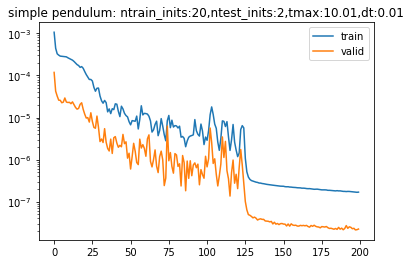

In [2]:
from model import HNN as HNN1
model_ft = HNN1(3, 200, 1, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model1 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)


epoch:0
train state loss 9.416220564162359e-05
train state loss 0.002817867323756218
train state loss 0.000619663274846971
train state loss 0.0001496143377153203
train state loss 0.00017855527403298765
train state loss 0.00025643431581556797
train state loss 0.0001664419105509296
train state loss 8.5796884377487e-05
train state loss 9.39939491217956e-05
train state loss 0.00012419930135365576
train state loss 0.00012145432992838323
train state loss 9.4011498731561e-05
train state loss 8.028861338971183e-05
train state loss 8.544031879864633e-05
train Loss: 0.0049679228
valid state loss 9.700439113657922e-05
valid state loss 0.0001226474269060418
valid Loss: 0.0002196518
epoch:1
train state loss 0.00010040584311354905
train state loss 0.000101248559076339
train state loss 9.420706919627264e-05
train state loss 8.056557271629572e-05
train state loss 7.118412759155035e-05
train state loss 7.541417289758101e-05
train state loss 8.121822611428797e-05
train state loss 7.629468746017665e-05
t

train state loss 1.950257683347445e-05
train state loss 2.0429162759683095e-05
train state loss 1.9236375010223128e-05
train state loss 1.886883364932146e-05
train state loss 1.9259068722021766e-05
train state loss 1.8233184164273553e-05
train state loss 1.9218976376578212e-05
train state loss 1.933712701429613e-05
train state loss 1.967753814824391e-05
train state loss 1.8492795788915828e-05
train state loss 1.891930696729105e-05
train state loss 1.9309325580252334e-05
train state loss 1.8188267858931795e-05
train state loss 1.8940880181617104e-05
train Loss: 0.0002676134
valid state loss 1.1753531907743309e-05
valid state loss 1.0919656233454589e-05
valid Loss: 0.0000226732
epoch:13
train state loss 2.05328924494097e-05
train state loss 1.918946873047389e-05
train state loss 1.8374965293332934e-05
train state loss 1.879350202216301e-05
train state loss 1.87692312465515e-05
train state loss 1.835729563026689e-05
train state loss 1.9823317416012287e-05
train state loss 1.92352672456763

valid state loss 8.225974852393847e-06
valid state loss 1.0647091585269663e-05
valid Loss: 0.0000188731
epoch:24
train state loss 1.0688030670280568e-05
train state loss 1.1534511941135861e-05
train state loss 1.0377326361776795e-05
train state loss 1.154828532889951e-05
train state loss 1.0848081728909165e-05
train state loss 1.0042061148851644e-05
train state loss 9.620717719371896e-06
train state loss 1.0127828318218235e-05
train state loss 1.0291877515555825e-05
train state loss 9.946638783731032e-06
train state loss 1.0343422218284104e-05
train state loss 9.736227184475865e-06
train state loss 1.0260275303153321e-05
train state loss 1.0829815437318757e-05
train Loss: 0.0001461951
valid state loss 6.826356184319593e-06
valid state loss 8.128498848236632e-06
valid Loss: 0.0000149549
epoch:25
train state loss 1.0309939170838334e-05
train state loss 1.2212953151902184e-05
train state loss 1.1497696505102795e-05
train state loss 9.43940358411055e-06
train state loss 1.0940748325083405e

valid state loss 4.878476829617284e-06
valid state loss 5.905622401769506e-06
valid Loss: 0.0000107841
epoch:36
train state loss 5.664408945449395e-06
train state loss 6.650899649685016e-06
train state loss 4.733045898319688e-06
train state loss 6.159701570140896e-06
train state loss 6.746393864887068e-06
train state loss 4.210035513096955e-06
train state loss 5.702529506379506e-06
train state loss 5.3349340305430815e-06
train state loss 3.858308446069714e-06
train state loss 7.258766800077865e-06
train state loss 5.684764346369775e-06
train state loss 4.339598035585368e-06
train state loss 6.7774212766380515e-06
train state loss 4.9490854507894255e-06
train Loss: 0.0000780699
valid state loss 4.966160759067861e-06
valid state loss 2.6572854494588682e-06
valid Loss: 0.0000076234
epoch:37
train state loss 4.5784731810272206e-06
train state loss 6.235862656467361e-06
train state loss 4.0580466702522244e-06
train state loss 5.128484190208837e-06
train state loss 5.170326858205954e-06
trai

valid state loss 3.7248066746542463e-06
valid state loss 5.564247203437844e-06
valid Loss: 0.0000092891
epoch:48
train state loss 3.608038241509348e-06
train state loss 2.563790758358664e-06
train state loss 2.0688919448730303e-06
train state loss 2.1643068066623528e-06
train state loss 3.509645694066421e-06
train state loss 3.1977258458937285e-06
train state loss 2.522718205000274e-06
train state loss 1.8839486983779352e-06
train state loss 2.7854414383909898e-06
train state loss 3.698803993756883e-06
train state loss 2.9584334697574377e-06
train state loss 2.0538609533105046e-06
train state loss 2.397196340098162e-06
train state loss 2.4800037863315083e-06
train Loss: 0.0000378928
valid state loss 2.5398837806278607e-06
valid state loss 1.5835380509088282e-06
valid Loss: 0.0000041234
epoch:49
train state loss 2.335868884983938e-06
train state loss 2.3468835479434347e-06
train state loss 2.3826521555747604e-06
train state loss 2.8882961942144902e-06
train state loss 3.0281544241006486

train Loss: 0.0000159934
valid state loss 1.0033450053015258e-06
valid state loss 1.2320722362346714e-06
valid Loss: 0.0000022354
epoch:60
train state loss 9.836738854573923e-07
train state loss 1.1941838238271885e-06
train state loss 1.3988575346957077e-06
train state loss 1.3827378779751598e-06
train state loss 9.445339514968509e-07
train state loss 1.1321126294205897e-06
train state loss 1.0767962521640584e-06
train state loss 1.3100964224577183e-06
train state loss 9.274417038795946e-07
train state loss 9.162146739072341e-07
train state loss 1.0518389217395452e-06
train state loss 1.0315878853361937e-06
train state loss 1.0630067208694527e-06
train state loss 1.0507967544981511e-06
train Loss: 0.0000154639
valid state loss 9.019183266900654e-07
valid state loss 1.230351927006268e-06
valid Loss: 0.0000021323
epoch:61
train state loss 1.0081312211696059e-06
train state loss 1.1091290161857614e-06
train state loss 1.3180635960452491e-06
train state loss 1.0388439477537759e-06
train st

train state loss 9.701816452434286e-07
train Loss: 0.0000135514
valid state loss 1.223215008394618e-06
valid state loss 2.721832743191044e-06
valid Loss: 0.0000039450
epoch:72
train state loss 1.6680143062330899e-06
train state loss 1.8398369547867333e-06
train state loss 1.0679950719350018e-06
train state loss 7.636224381712964e-07
train state loss 1.0443287692396552e-06
train state loss 1.1178692602697993e-06
train state loss 8.933469075600442e-07
train state loss 7.71927432197117e-07
train state loss 7.136084718695201e-07
train state loss 9.804342653296771e-07
train state loss 1.002082171908114e-06
train state loss 8.481841291541059e-07
train state loss 6.373417704708118e-07
train state loss 8.913265787668934e-07
train Loss: 0.0000142399
valid state loss 1.2955448482898646e-06
valid state loss 8.582945270063647e-07
valid Loss: 0.0000021538
epoch:73
train state loss 9.998107088904362e-07
train state loss 8.839663223625394e-07
train state loss 6.784605943721544e-07
train state loss 7.

train state loss 6.712868412250828e-07
train Loss: 0.0000135848
valid state loss 5.561511216001236e-07
valid state loss 8.089294283308845e-07
valid Loss: 0.0000013651
epoch:84
train state loss 6.568437811438343e-07
train state loss 6.633192697336199e-07
train state loss 6.3503756564387e-07
train state loss 6.42999395950028e-07
train state loss 6.528063067889889e-07
train state loss 7.042720540084701e-07
train state loss 6.559928920069069e-07
train state loss 4.7523494117740483e-07
train state loss 7.685491709708003e-07
train state loss 1.0194777360084117e-06
train state loss 1.5880007140367525e-06
train state loss 2.7440567009762162e-06
train state loss 2.7510900508787017e-06
train state loss 2.0832794689340517e-06
train Loss: 0.0000160410
valid state loss 1.1364392094037612e-06
valid state loss 1.3083347312203841e-06
valid Loss: 0.0000024448
epoch:85
train state loss 1.36808830575319e-06
train state loss 1.1018687473551836e-06
train state loss 1.8083285340253497e-06
train state loss 1

train state loss 2.255015942864702e-07
train Loss: 0.0000045616
valid state loss 2.2376197250650876e-07
valid state loss 3.5774161233348423e-07
valid Loss: 0.0000005815
epoch:96
train state loss 2.7552530923458107e-07
train state loss 3.457611796875426e-07
train state loss 4.6883707227607374e-07
train state loss 6.07375454819703e-07
train state loss 7.050540489217383e-07
train state loss 7.437413387378911e-07
train state loss 5.118229751133185e-07
train state loss 3.7534431385211064e-07
train state loss 2.398102196821128e-07
train state loss 4.891977596344077e-07
train state loss 6.051721470612392e-07
train state loss 7.839080922167341e-07
train state loss 5.526612198991643e-07
train state loss 4.773727937390504e-07
train Loss: 0.0000071816
valid state loss 5.730646535084816e-07
valid state loss 3.503871255361446e-07
valid Loss: 0.0000009235
epoch:97
train state loss 4.780189897246601e-07
train state loss 4.4719567426909634e-07
train state loss 3.05521353993754e-07
train state loss 2.5

train state loss 5.145305976839154e-07
train state loss 3.7017554177509737e-07
train Loss: 0.0000101930
valid state loss 3.06241531689011e-07
valid state loss 4.176658023880009e-07
valid Loss: 0.0000007239
epoch:108
train state loss 3.629432114848896e-07
train state loss 2.898683817420533e-07
train state loss 4.5683228222515027e-07
train state loss 4.315394619425206e-07
train state loss 4.472522618925723e-07
train state loss 3.171797970935586e-07
train state loss 3.117294511412183e-07
train state loss 3.037568774288957e-07
train state loss 2.701852110931213e-07
train state loss 3.534696304541285e-07
train state loss 3.4435350926287356e-07
train state loss 3.1627973839931656e-07
train state loss 3.445096581344842e-07
train state loss 2.399627589966258e-07
train Loss: 0.0000047899
valid state loss 1.9818067187316046e-07
valid state loss 1.5535815123257635e-07
valid Loss: 0.0000003535
epoch:109
train state loss 1.9968285869254032e-07
train state loss 3.34024349513129e-07
train state loss 

train state loss 1.3614182137189346e-07
train state loss 1.5023974242467375e-07
train Loss: 0.0000021542
valid state loss 1.4575276452433172e-07
valid state loss 1.388801820212393e-07
valid Loss: 0.0000002846
epoch:120
train state loss 1.4099593670380273e-07
train state loss 1.7131559104655025e-07
train state loss 2.3269410576176597e-07
train state loss 2.48533979174681e-07
train state loss 2.065712152443666e-07
train state loss 1.6253058277015953e-07
train state loss 1.6089852294953744e-07
train state loss 1.5586830670599738e-07
train state loss 1.3911821383771894e-07
train state loss 1.2595039322604862e-07
train state loss 1.1140593869640725e-07
train state loss 9.38337265665723e-08
train state loss 1.1468811322856709e-07
train state loss 1.2966403062364407e-07
train Loss: 0.0000021941
valid state loss 1.4050120000774768e-07
valid state loss 1.070956159310299e-07
valid Loss: 0.0000002476
epoch:121
train state loss 1.3353371741686715e-07
train state loss 1.0676533435116653e-07
train s

train state loss 6.635493576823137e-08
train state loss 6.679559305666771e-08
train Loss: 0.0000009375
valid state loss 5.5480413152508845e-08
valid state loss 8.259408446065208e-08
valid Loss: 0.0000001381
epoch:132
train state loss 6.904325289269764e-08
train state loss 6.418320452894477e-08
train state loss 7.457348516481943e-08
train state loss 6.767482574332462e-08
train state loss 7.026926596154226e-08
train state loss 6.052421497315663e-08
train state loss 6.109760164463296e-08
train state loss 6.790664031086635e-08
train state loss 6.708988564696483e-08
train state loss 6.881551684045917e-08
train state loss 6.031778099213625e-08
train state loss 6.268174246315539e-08
train state loss 5.937906166764151e-08
train state loss 5.607946462760083e-08
train Loss: 0.0000009096
valid state loss 5.420592685823067e-08
valid state loss 7.688977632369642e-08
valid Loss: 0.0000001311
epoch:133
train state loss 6.22195912569623e-08
train state loss 6.041806699386143e-08
train state loss 6.958

train Loss: 0.0000008069
valid state loss 4.701643874227557e-08
valid state loss 6.148301423536395e-08
valid Loss: 0.0000001085
epoch:144
train state loss 5.791666168875054e-08
train state loss 5.7525674890257505e-08
train state loss 6.184117040675119e-08
train state loss 5.2517542314944876e-08
train state loss 5.733329899726414e-08
train state loss 5.454146645433866e-08
train state loss 5.6906419132474184e-08
train state loss 6.005338093473256e-08
train state loss 5.850957762731923e-08
train state loss 5.744562514564677e-08
train state loss 5.7680139775584394e-08
train state loss 5.694493410146606e-08
train state loss 5.594202434622275e-08
train state loss 4.855117197166692e-08
train Loss: 0.0000007937
valid state loss 4.893782445947181e-08
valid state loss 6.431023535924396e-08
valid Loss: 0.0000001132
epoch:145
train state loss 5.668741209774453e-08
train state loss 6.032780675013782e-08
train state loss 5.783008560911185e-08
train state loss 5.7910327200261236e-08
train state loss 

valid state loss 4.4215862970986564e-08
valid state loss 6.472060221085485e-08
valid Loss: 0.0000001089
epoch:156
train state loss 5.290745619390691e-08
train state loss 5.6700809381027284e-08
train state loss 4.976530831868331e-08
train state loss 5.1628166630734995e-08
train state loss 4.9320689754495106e-08
train state loss 5.227564159326903e-08
train state loss 5.30194377290627e-08
train state loss 4.983014179060774e-08
train state loss 5.27664347771406e-08
train state loss 5.338565145507346e-08
train state loss 5.374669242996788e-08
train state loss 6.119638129575833e-08
train state loss 5.0371109949765014e-08
train state loss 4.7294946625697776e-08
train Loss: 0.0000007342
valid state loss 4.5324764386123206e-08
valid state loss 5.1442519577449275e-08
valid Loss: 0.0000000968
epoch:157
train state loss 5.560411153737732e-08
train state loss 4.875215253719034e-08
train state loss 4.961825794680408e-08
train state loss 5.5861747227936576e-08
train state loss 5.193869512254423e-08
t

train state loss 4.4345970451331596e-08
train Loss: 0.0000006748
valid state loss 4.0657486266582055e-08
valid state loss 5.113639645060175e-08
valid Loss: 0.0000000918
epoch:168
train state loss 4.378732398890861e-08
train state loss 4.999242975145535e-08
train state loss 4.6824634836184487e-08
train state loss 5.5538404097887906e-08
train state loss 5.044114459451521e-08
train state loss 4.6054353219915356e-08
train state loss 4.903709083237118e-08
train state loss 5.0038881482805664e-08
train state loss 4.62492302233386e-08
train state loss 4.765802330553015e-08
train state loss 4.651754892393001e-08
train state loss 4.6605137526967155e-08
train state loss 4.322474822515687e-08
train state loss 5.176673667506293e-08
train Loss: 0.0000006737
valid state loss 4.2438639269448686e-08
valid state loss 4.57211370985533e-08
valid Loss: 0.0000000882
epoch:169
train state loss 4.5234287426865194e-08
train state loss 4.953673737873032e-08
train state loss 4.694869204513452e-08
train state los

train state loss 4.423598554126329e-08
train Loss: 0.0000006243
valid state loss 4.054228952554695e-08
valid state loss 4.271399234312412e-08
valid Loss: 0.0000000833
epoch:180
train state loss 4.5437410278736934e-08
train state loss 4.700774525190354e-08
train state loss 4.258340879914613e-08
train state loss 4.3505966829116005e-08
train state loss 4.367554495843251e-08
train state loss 3.8872478569373925e-08
train state loss 4.437160683323782e-08
train state loss 4.729359304178615e-08
train state loss 4.781707474421637e-08
train state loss 4.505463024884193e-08
train state loss 4.7203130293382856e-08
train state loss 4.278245668842828e-08
train state loss 4.227247529797751e-08
train state loss 4.1544261364379054e-08
train Loss: 0.0000006194
valid state loss 3.6287538307533396e-08
valid state loss 4.609320214399304e-08
valid Loss: 0.0000000824
epoch:181
train state loss 4.319483792869505e-08
train state loss 4.306976464363288e-08
train state loss 4.0479246621316634e-08
train state los

train Loss: 0.0000005931
valid state loss 3.769096679206996e-08
valid state loss 4.0684998481310686e-08
valid Loss: 0.0000000784
epoch:192
train state loss 4.47555805749289e-08
train state loss 3.9463571965825395e-08
train state loss 4.2290817958701155e-08
train state loss 4.143747034390799e-08
train state loss 4.262380670638777e-08
train state loss 4.149425336663626e-08
train state loss 3.9195107603973156e-08
train state loss 4.197901404268123e-08
train state loss 3.9827845910167525e-08
train state loss 4.128046526830076e-08
train state loss 4.038820122787001e-08
train state loss 4.172749612507687e-08
train state loss 4.1869348876844015e-08
train state loss 3.886847110834424e-08
train Loss: 0.0000005772
valid state loss 3.831108230656355e-08
valid state loss 3.8239388544525355e-08
valid Loss: 0.0000000766
epoch:193
train state loss 3.9086824443756996e-08
train state loss 4.3162454943512785e-08
train state loss 4.417259447109245e-08
train state loss 4.220422056278039e-08
train state lo

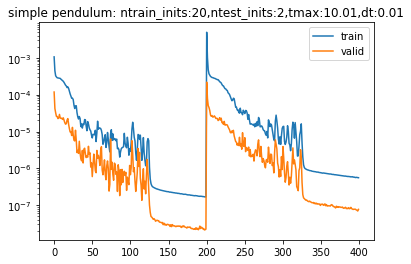

In [3]:
from model_type_I import HNN as HNN2
model_ft = HNN2(3, 200, 2, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model2 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)


epoch:0
train state loss 0.00010475290764588863
train state loss 0.0018901298753917217
train state loss 0.00018781864491757005
train state loss 0.00021567328076343983
train state loss 0.0002537469263188541
train state loss 0.00012510585656855255
train state loss 8.732279093237594e-05
train state loss 0.00010953648597933352
train state loss 0.0001404313516104594
train state loss 0.00014651883975602686
train state loss 0.00013661544653587043
train state loss 0.00010438560275360942
train state loss 9.108163794735447e-05
train state loss 9.718207002151757e-05
train Loss: 0.0036903024
valid state loss 9.509611845714971e-05
valid state loss 0.00014149252092465758
valid Loss: 0.0002365886
epoch:1
train state loss 9.625255916034803e-05
train state loss 0.00010180256504099816
train state loss 0.00010754142567748204
train state loss 0.00010245013982057571
train state loss 9.482005407335237e-05
train state loss 8.867125870892778e-05
train state loss 9.123983181780204e-05
train state loss 9.536180

train state loss 2.1252331862342544e-05
train state loss 1.9681852791109122e-05
train state loss 2.0636820408981293e-05
train state loss 2.011594369832892e-05
train state loss 2.1186126105021685e-05
train state loss 1.9201572285965085e-05
train state loss 1.9757022528210655e-05
train state loss 1.9164966943208128e-05
train state loss 1.8434451703797095e-05
train state loss 1.9979861463070847e-05
train state loss 1.9083203369518742e-05
train state loss 1.9910305127268657e-05
train state loss 1.968099059013184e-05
train state loss 1.9907209207303822e-05
train Loss: 0.0002779927
valid state loss 1.535060982860159e-05
valid state loss 1.2400092600728385e-05
valid Loss: 0.0000277507
epoch:13
train state loss 1.952962156792637e-05
train state loss 2.042464075202588e-05
train state loss 1.999936102947686e-05
train state loss 1.910245009639766e-05
train state loss 2.065868284262251e-05
train state loss 2.063355168502312e-05
train state loss 1.9405029888730496e-05
train state loss 1.95012853509

valid state loss 1.1338145668560173e-05
valid state loss 5.963123385299696e-06
valid Loss: 0.0000173013
epoch:24
train state loss 1.2520662494353019e-05
train state loss 1.2599119145306759e-05
train state loss 1.1913581147382502e-05
train state loss 1.2368667739792727e-05
train state loss 1.2242965567565989e-05
train state loss 1.2135315955674741e-05
train state loss 1.2020237591059413e-05
train state loss 1.2015989341307431e-05
train state loss 1.2291240636841394e-05
train state loss 1.1188475582457613e-05
train state loss 1.1553291187738068e-05
train state loss 1.1597475349844899e-05
train state loss 1.1630421795416623e-05
train state loss 1.2001421055174433e-05
train Loss: 0.0001680789
valid state loss 1.191452429338824e-05
valid state loss 5.609959771391004e-06
valid Loss: 0.0000175245
epoch:25
train state loss 1.17564004540327e-05
train state loss 1.1485421055112965e-05
train state loss 1.156986127170967e-05
train state loss 1.1595260730246082e-05
train state loss 1.18568068501190

valid state loss 8.613722457084805e-06
valid state loss 5.447929197543999e-06
valid Loss: 0.0000140617
epoch:36
train state loss 8.466820872854441e-06
train state loss 8.587821866967715e-06
train state loss 8.35095124784857e-06
train state loss 7.880781595304143e-06
train state loss 8.630388947494794e-06
train state loss 7.66888479120098e-06
train state loss 8.083325155894272e-06
train state loss 8.076153790170792e-06
train state loss 8.097496902337298e-06
train state loss 8.126645298034418e-06
train state loss 7.977106179168914e-06
train state loss 7.425278454320505e-06
train state loss 7.515093784604687e-06
train state loss 7.930298124847468e-06
train Loss: 0.0001128170
valid state loss 7.82933238951955e-06
valid state loss 2.5679546524770558e-06
valid Loss: 0.0000103973
epoch:37
train state loss 7.276008091139374e-06
train state loss 8.087222340691369e-06
train state loss 7.393417035927996e-06
train state loss 7.807327165210154e-06
train state loss 7.461286259058397e-06
train state 

valid state loss 8.120874213091156e-07
valid state loss 1.3415151443041395e-06
valid Loss: 0.0000021536
epoch:48
train state loss 1.1511457387314294e-06
train state loss 1.241196855517046e-06
train state loss 9.958347391147981e-07
train state loss 9.262361686523946e-07
train state loss 1.020052195599419e-06
train state loss 8.981058954304899e-07
train state loss 1.0743915481725708e-06
train state loss 1.111815890908474e-06
train state loss 8.794991117611062e-07
train state loss 8.060264917730819e-07
train state loss 1.0011734730142052e-06
train state loss 8.697908810972876e-07
train state loss 9.217513934345334e-07
train state loss 1.0115895747730974e-06
train Loss: 0.0000139086
valid state loss 6.979648219385126e-07
valid state loss 1.3655383099830942e-06
valid Loss: 0.0000020635
epoch:49
train state loss 9.756359986567986e-07
train state loss 8.779283007243066e-07
train state loss 8.90017474830529e-07
train state loss 8.851974371282267e-07
train state loss 7.36388471977989e-07
train 

valid state loss 2.4708197088330053e-07
valid state loss 5.038186259298527e-07
valid Loss: 0.0000007509
epoch:60
train state loss 3.976489324486465e-07
train state loss 3.0730748790119833e-07
train state loss 3.171368234688998e-07
train state loss 3.7270547181833535e-07
train state loss 2.8271475116525835e-07
train state loss 3.1911412179397303e-07
train state loss 3.6343047327136446e-07
train state loss 3.1939703148964327e-07
train state loss 3.437749001022894e-07
train state loss 2.9225392950138485e-07
train state loss 3.0140225248942443e-07
train state loss 3.26644681081234e-07
train state loss 3.808365818258608e-07
train state loss 2.813545734170475e-07
train Loss: 0.0000046057
valid state loss 2.324351981997097e-07
valid state loss 5.253866675047902e-07
valid Loss: 0.0000007578
epoch:61
train state loss 2.543434618473839e-07
train state loss 3.336108136409166e-07
train state loss 3.667111059257877e-07
train state loss 3.8366752619367617e-07
train state loss 3.7942015751468716e-07


train state loss 1.4203592968442535e-07
train Loss: 0.0000021712
valid state loss 1.2835135976274614e-07
valid state loss 2.4211604454649205e-07
valid Loss: 0.0000003705
epoch:72
train state loss 1.5479649562166742e-07
train state loss 1.5849134626932937e-07
train state loss 1.3970527845685865e-07
train state loss 1.5568964784051786e-07
train state loss 1.5863479063682462e-07
train state loss 1.6073127540039422e-07
train state loss 1.355660259605429e-07
train state loss 1.279782395613438e-07
train state loss 1.3273267995828064e-07
train state loss 1.1853618531176835e-07
train state loss 1.323823823895509e-07
train state loss 1.7596818224774324e-07
train state loss 1.265693185814598e-07
train state loss 1.099494326695094e-07
train Loss: 0.0000019877
valid state loss 1.1625937190729019e-07
valid state loss 2.073636409249957e-07
valid Loss: 0.0000003236
epoch:73
train state loss 1.2837111285080027e-07
train state loss 1.7556284603870154e-07
train state loss 1.9279191576515586e-07
train st

train state loss 1.7281369935062685e-07
train state loss 1.210536026974296e-07
train Loss: 0.0000024717
valid state loss 1.0971739783371959e-07
valid state loss 1.3665110998317687e-07
valid Loss: 0.0000002464
epoch:84
train state loss 1.207090463140048e-07
train state loss 5.957860338412502e-08
train state loss 1.0308791331681277e-07
train state loss 1.3355129624414985e-07
train state loss 1.5275877274234517e-07
train state loss 1.4400237091649615e-07
train state loss 1.8828711745300097e-07
train state loss 2.1500930813544983e-07
train state loss 1.7873858837447187e-07
train state loss 1.447166937396105e-07
train state loss 8.528117945161284e-08
train state loss 1.005272807219626e-07
train state loss 7.753840236546239e-08
train state loss 8.950431151788507e-08
train Loss: 0.0000017933
valid state loss 6.838968857891814e-08
valid state loss 1.1272977928911132e-07
valid Loss: 0.0000001811
epoch:85
train state loss 8.28020887411185e-08
train state loss 9.184016391827754e-08
train state lo

train state loss 2.935722953623099e-08
train state loss 3.681143923017771e-08
train Loss: 0.0000007392
valid state loss 4.6731194913718355e-08
valid state loss 8.415961616492496e-08
valid Loss: 0.0000001309
epoch:96
train state loss 5.009999171079471e-08
train state loss 5.3578769865225695e-08
train state loss 4.8556390908061076e-08
train state loss 4.4513935648637926e-08
train state loss 3.661801173393542e-08
train state loss 2.847312075004993e-08
train state loss 3.1232346486831375e-08
train state loss 3.977202922555989e-08
train state loss 6.312262712526717e-08
train state loss 1.0933258209888663e-07
train state loss 1.6190118401482323e-07
train state loss 1.896497963116417e-07
train state loss 1.517691288199785e-07
train state loss 8.096760240050571e-08
train Loss: 0.0000010896
valid state loss 3.3157000700612116e-08
valid state loss 4.188552793493727e-08
valid Loss: 0.0000000750
epoch:97
train state loss 3.645923030148879e-08
train state loss 5.101500022419714e-08
train state loss

train state loss 2.3609935340118682e-07
train state loss 2.946556492133823e-07
train Loss: 0.0000019509
valid state loss 1.6071916775217687e-07
valid state loss 4.025090447612456e-07
valid Loss: 0.0000005632
epoch:108
train state loss 2.0349160934074462e-07
train state loss 5.3277936729045905e-08
train state loss 6.56282992395063e-08
train state loss 2.034142738693845e-07
train state loss 4.747529089854652e-07
train state loss 7.59500778713118e-07
train state loss 7.375729182967916e-07
train state loss 5.293608182910248e-07
train state loss 2.8617733960345504e-07
train state loss 1.3567827750193828e-07
train state loss 2.1136838768143207e-07
train state loss 3.5240083207099815e-07
train state loss 3.8841218952256895e-07
train state loss 3.2049737797024136e-07
train Loss: 0.0000047215
valid state loss 8.759552372339385e-08
valid state loss 1.9515169924488873e-07
valid Loss: 0.0000002827
epoch:109
train state loss 1.1472049976646304e-07
train state loss 1.124201531865765e-07
train state 

train state loss 9.671163780922143e-08
train state loss 3.155687977596244e-08
train state loss 8.558676256598119e-08
train state loss 2.558595326718205e-07
train Loss: 0.0000026097
valid state loss 5.194794425733562e-07
valid state loss 1.3598728401120752e-06
valid Loss: 0.0000018794
epoch:120
train state loss 6.847452027614054e-07
train state loss 1.1201851748410263e-06
train state loss 1.3640068345921463e-06
train state loss 8.366951647076348e-07
train state loss 2.0233625264154398e-07
train state loss 1.390182546856522e-07
train state loss 5.749545266553469e-07
train state loss 9.380065080222266e-07
train state loss 6.965923944335373e-07
train state loss 2.9269486390148813e-07
train state loss 9.659643751547264e-08
train state loss 3.4860039477280225e-07
train state loss 8.369739816771471e-07
train state loss 8.156376338774862e-07
train Loss: 0.0000089470
valid state loss 2.936405678610754e-07
valid state loss 6.03418641276221e-07
valid Loss: 0.0000008971
epoch:121
train state loss 

train state loss 9.143366064279235e-09
train state loss 8.960585162753887e-09
train state loss 1.0302854569488318e-08
train state loss 9.338621431709271e-09
train state loss 1.0227188873557225e-08
train state loss 9.993587291035055e-09
train Loss: 0.0000001359
valid state loss 1.0317544152371738e-08
valid state loss 9.045448834399394e-09
valid Loss: 0.0000000194
epoch:132
train state loss 1.0151446794282037e-08
train state loss 9.289936819811828e-09
train state loss 9.387091104429146e-09
train state loss 1.0586238552434679e-08
train state loss 9.251216681605001e-09
train state loss 1.0894126489802147e-08
train state loss 9.029137437721602e-09
train state loss 9.394588218469835e-09
train state loss 9.656949018221894e-09
train state loss 9.23087206672335e-09
train state loss 9.663796873837782e-09
train state loss 1.0132398919893149e-08
train state loss 9.459303562664445e-09
train state loss 1.0434742847564848e-08
train Loss: 0.0000001366
valid state loss 1.0342202649837873e-08
valid stat

train state loss 9.324594429926947e-09
train state loss 9.132334888306559e-09
train state loss 8.260348849375987e-09
train state loss 8.464221323833954e-09
train state loss 9.026372538301075e-09
train state loss 9.854589144708825e-09
train Loss: 0.0000001293
valid state loss 9.694433700246918e-09
valid state loss 8.248236760266536e-09
valid Loss: 0.0000000179
epoch:144
train state loss 9.952153767756045e-09
train state loss 8.827022668356221e-09
train state loss 9.594626426689956e-09
train state loss 9.612817208903834e-09
train state loss 9.126768674150298e-09
train state loss 9.206458706501053e-09
train state loss 9.076216223036226e-09
train state loss 8.543851848230588e-09
train state loss 9.040865833753742e-09
train state loss 9.138607204306481e-09
train state loss 8.539092100079415e-09
train state loss 1.0017842555498646e-08
train state loss 9.085346697190744e-09
train state loss 7.775471821958035e-09
train Loss: 0.0000001275
valid state loss 9.78600755985326e-09
valid state loss 8

train state loss 9.17803166800013e-09
train state loss 8.686229513443777e-09
train state loss 8.728004985414373e-09
train state loss 9.080585172682731e-09
train Loss: 0.0000001218
valid state loss 9.238707576741945e-09
valid state loss 7.663126133650167e-09
valid Loss: 0.0000000169
epoch:156
train state loss 8.712656374143535e-09
train state loss 7.99087285230371e-09
train state loss 9.765198427658106e-09
train state loss 8.842229171079907e-09
train state loss 8.622704328331565e-09
train state loss 8.744087232059883e-09
train state loss 7.944949587113115e-09
train state loss 8.510421700691495e-09
train state loss 9.040561188555785e-09
train state loss 8.090077940892115e-09
train state loss 8.041748600362553e-09
train state loss 9.755130037092385e-09
train state loss 8.868236811565566e-09
train state loss 7.416854241881765e-09
train Loss: 0.0000001203
valid state loss 9.13520636913745e-09
valid state loss 7.677961377794418e-09
valid Loss: 0.0000000168
epoch:157
train state loss 8.876285

train state loss 8.392781580823794e-09
train state loss 8.914287974448598e-09
train Loss: 0.0000001155
valid state loss 8.736861012437203e-09
valid state loss 7.018041703332756e-09
valid Loss: 0.0000000158
epoch:168
train state loss 7.791916445398783e-09
train state loss 8.375517168701663e-09
train state loss 7.838609761279258e-09
train state loss 8.331390688454121e-09
train state loss 7.551206770983754e-09
train state loss 7.565629012162844e-09
train state loss 8.14162870454993e-09
train state loss 8.770718373796171e-09
train state loss 8.205194745869449e-09
train state loss 8.68900418282692e-09
train state loss 9.216843288584187e-09
train state loss 8.032686515946352e-09
train state loss 8.219545932774963e-09
train state loss 7.58848006654489e-09
train Loss: 0.0000001143
valid state loss 8.767912618168339e-09
valid state loss 6.952890707623283e-09
valid Loss: 0.0000000157
epoch:169
train state loss 7.604834095786828e-09
train state loss 8.766567916040913e-09
train state loss 8.094507

train state loss 8.086497693682304e-09
train state loss 7.714914929124461e-09
train Loss: 0.0000001092
valid state loss 8.400053097545879e-09
valid state loss 6.855065404209881e-09
valid Loss: 0.0000000153
epoch:180
train state loss 8.446003008089065e-09
train state loss 7.991083350589179e-09
train state loss 6.925254592005103e-09
train state loss 7.56978657534546e-09
train state loss 7.488403674926758e-09
train state loss 8.653674221648089e-09
train state loss 8.106110449546122e-09
train state loss 7.175054772545764e-09
train state loss 8.381545235636167e-09
train state loss 7.84088616256895e-09
train state loss 7.91626231233522e-09
train state loss 8.195638834251895e-09
train state loss 7.766081111526546e-09
train state loss 7.899148002366019e-09
train Loss: 0.0000001104
valid state loss 8.399182682694573e-09
valid state loss 6.383570561041552e-09
valid Loss: 0.0000000148
epoch:181
train state loss 7.84266163122993e-09
train state loss 7.691700609768759e-09
train state loss 7.7130373

valid state loss 7.808490742888807e-09
valid state loss 6.0606573093480165e-09
valid Loss: 0.0000000139
epoch:192
train state loss 7.688664815930224e-09
train state loss 7.317461303557593e-09
train state loss 6.967967536297692e-09
train state loss 7.160705361997088e-09
train state loss 7.2649939397706476e-09
train state loss 6.943430719275057e-09
train state loss 7.822722025707662e-09
train state loss 7.911607369237572e-09
train state loss 7.356084630316673e-09
train state loss 7.3310282289185125e-09
train state loss 6.96794399956957e-09
train state loss 7.255475331646721e-09
train state loss 7.829890513733062e-09
train state loss 6.857947987271018e-09
train Loss: 0.0000001027
valid state loss 7.911893362688716e-09
valid state loss 6.042325750854616e-09
valid Loss: 0.0000000140
epoch:193
train state loss 7.181431449510001e-09
train state loss 7.475949637125723e-09
train state loss 6.822213016732803e-09
train state loss 8.109615201590259e-09
train state loss 7.448210492810858e-09
train 

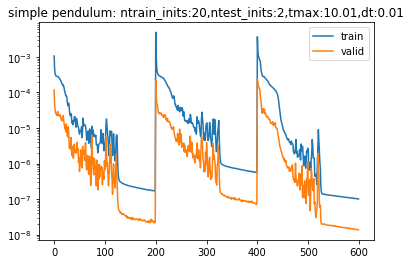

In [4]:
from model_type_II import HNN as HNN3
model_ft = HNN3(2, 200, 1, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model3 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)

# torch.save(trained_model,'HNN_painleve')

#### MAKE SURE TO SPECIFY THE MODEL TYPE UNDER INFERENCE MODEL

In [9]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

# %%


inference_model = trained_model3

n_test_traj = 1
num_nodes = 2
T_max_t = 10.01
dt = 0.01
srate = 0.01

bs = int(T_max_t//dt)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 1)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)

# tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)


# traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
# train_dataloader = DataLoader(traindat, batch_size=200, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=bs, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}


phase = 'valid'

main_pred =[]
for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict['valid']):
    if phase == 'train':
        optimizer.zero_grad()
    q, q_next, qdx = q.float(), q_next.float(), qdx.float()
    q.to(device)
    q_next.to(device)
    energy_.to(device)
    qdx.to(device)
    tevals = tevals.float()
    tevals.to(device)
    loss = 0
    q.requires_grad = True
    tevals.requires_grad = True

    qinit = q[0].reshape(1, -1)

    preds = []
    for i in range(len(q_next)):
        next_step_pred = inference_model.next_step(qinit,tevals[i])
        preds.append(next_step_pred)
        qinit = next_step_pred

    preds = torch.cat(preds).detach().numpy()
    q_next = q_next.detach().numpy()

    main_pred.append((preds,q_next))
    

cpu


KeyboardInterrupt: 

In [10]:
preds = torch.cat(preds).detach().numpy()
q_next = q_next.detach().numpy()

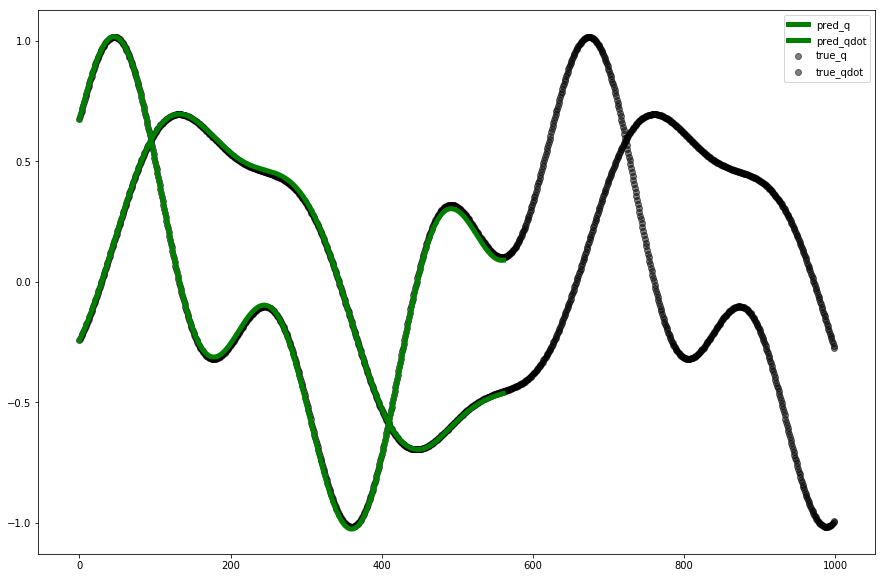

In [8]:
for j in range(n_test_traj):
#     preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

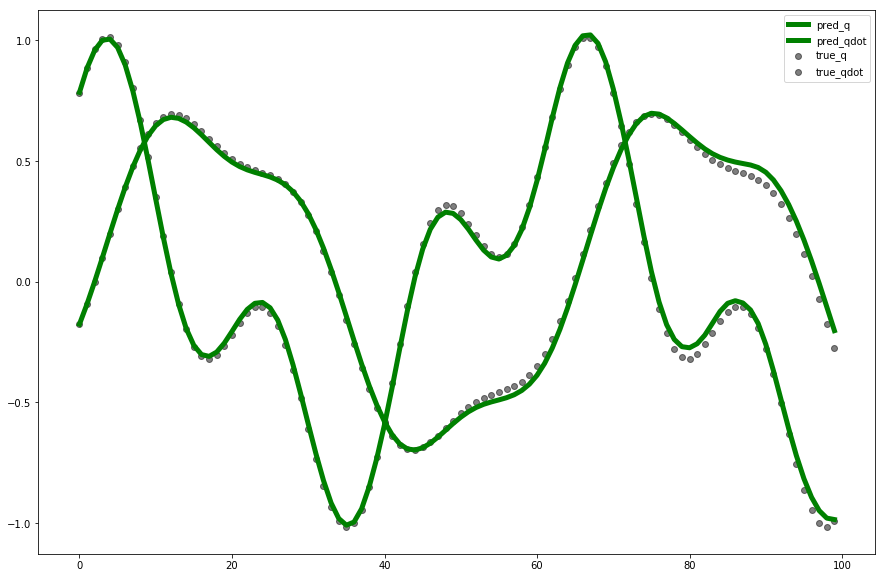

In [8]:
for j in range(n_test_traj):
    preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

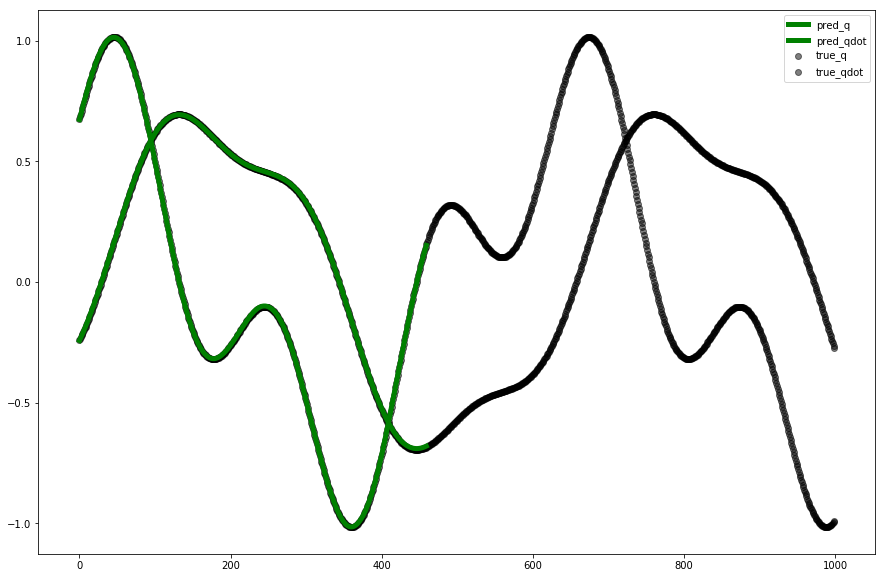

In [11]:
for j in range(n_test_traj):
#     preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

In [15]:
tevals.shape

torch.Size([100])

In [12]:
tsteps =tevals.detach().numpy()

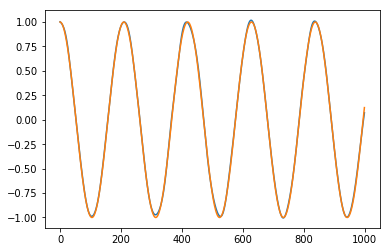

In [20]:
plt.plot(trained_model3.get_F(tevals.reshape(-1,1)).detach().numpy())
plt.plot(np.cos(3*tsteps))

## evidence suggests that learning the force separately leads to better inference despite comparable state loss.. basically the new regularization only helps a little

In [8]:
torch.tensor(tnow).split(1,1)

(tensor([[0.2323],
         [0.2426],
         [0.2529],
         ...,
         [0.6765],
         [0.6699],
         [0.6633]], dtype=torch.float64), tensor([[ 1.0241],
         [ 1.0317],
         [ 1.0392],
         ...,
         [-0.6529],
         [-0.6588],
         [-0.6644]], dtype=torch.float64))

In [9]:
tnow

array([[ 0.2323083 ,  1.02410753],
       [ 0.24258759,  1.0317316 ],
       [ 0.25294256,  1.03924355],
       ...,
       [ 0.6764828 , -0.65291534],
       [ 0.66992368, -0.6588496 ],
       [ 0.66330703, -0.66441935]])